
Reinforcement Learning (DQN) tutorial - TTbot
======================================

<img src="https://www.naverlabs.com/naverlabs_/story/201803/1520480681892_TTbot_%ED%9D%B0%EB%B0%B0%EA%B2%BD.png" alt="Drawing" style="width: 600px;"/>


In [93]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import cv2
import random
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

writer = SummaryWriter()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TTBot Simulator
---

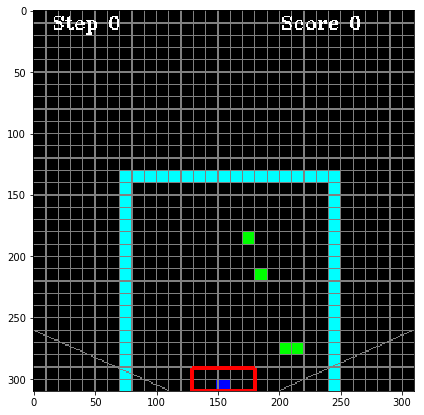

In [94]:
simulator = {"width":31, "height":31, "center":15, "resol":3}
map_param = {"width":100, "height":100, "center":50, "resol":1, "scale":5, "Map.data.obstacle": 200, "Map.data.ball": 1}
# walls_samples = [[1.2,2.0],[1.4,2.0],[1.6,2.0],[1.2,4.0],[1.4,4.0],[1.6,4.0],[1.2,-2.0],[1.4,-2.0],[1.6,-2.0],[1.2,-4.0],[1.4,-4.0],[1.6,-4.0]]
walls_samples = [[1.5,-30.0],[30.4,0.7],[-30.4,-0.7]]

camera_fov = 120
ball_blind_ratio = 1/np.tan(camera_fov/2*np.pi/180)
ball_blind_bias = 5

reward_region_x = 2
reward_region_y = [0,1,2,3]

trans_scale = int(simulator["resol"]/map_param["resol"])
rot_scale = 20

debug_scale = 10
debug_scale_gray = 3

max_iter = 99

class TTbotGym:
    def __init__(self, debug_flag=False, mlp_flag=False, test_flag=False, state_blink=True, state_inaccurate=True):
        self.frame = np.zeros((simulator["height"],simulator["width"],1), np.uint8)
        self.frame_gray = np.zeros((simulator["height"]*debug_scale_gray,simulator["width"]*debug_scale_gray,1), np.uint8)
        self.balls = []
        self.balls_prev = []
        self.obstacles = []
        self.episode_rewards = []
        self.score = 0
        self.iter = 0
        self.done = False

        self.write_flag = False
        self.debug_flag = debug_flag
        self.mlp_flag = mlp_flag
        self.test_flag = test_flag
        self.ball_inscreen_flag = 0
        self.state_blink = state_blink
        self.state_inaccurate = state_inaccurate

        ############################################################
        # Flag Setups
        # debug_flag : Display colored map for demonstration
        # mlp_flag : If true, step() returns small 31x31 gray scale image for Multi Layer Perception.
        #            If false, step() returns 93x93 gray scale image for Convolutional Neural Network
        # test_flag : Whether it is training phase or test phase. During the test phase, the simulator saves every demonstration in form of video
        # write_flag : If true, it records videos
        # state_blink : Simulate target's detection error
        # state_inaccurate : Simulate target's position estimation error
        ############################################################

        ## DQN parameters
        if self.mlp_flag:
            self.observation_space = self.frame.copy()
        else:
            self.observation_space = self.frame_gray.copy()

        self.action_space = np.array(range(10))


        # self.reset(max_balls=20, max_walls=3)
        return

    def reset(self, max_balls=20, max_walls=2):
        self.frame = np.zeros((simulator["height"],simulator["width"],1), np.uint8)
        self.frame_gray = np.zeros((simulator["height"]*debug_scale_gray,simulator["width"]*debug_scale_gray,1), np.uint8)
        self.balls = []
        self.balls_prev = []
        self.obstacles = []
        self.score = 0
        self.iter = 0
        self.done = False
        self.write_flag = False
        self.ball_inscreen_flag = 0

        if len(self.episode_rewards)%5000 == 0 and not self.test_flag:
            self.write_flag = True
            out_directory = "data/video/tt.video."+format(len(self.episode_rewards)/5000,"06")+".mp4"

        if self.test_flag:
            self.write_flag = True
            out_directory = "data/video_test/tt.video."+format(len(self.episode_rewards),"06")+".mp4"

        if self.write_flag:
            codec = cv2.VideoWriter_fourcc(*'H264')
            fps = 10
            self.video = cv2.VideoWriter(out_directory, codec, fps, (simulator["width"]*debug_scale,simulator["height"]*debug_scale))

        num_walls = int((max_walls+1)*random.random())
        # walls_sampled = random.sample(walls_samples, num_walls)
        rand_direction = random.random()
        if rand_direction >= 0.666:
            walls_sampled = [[random.random()+0.7,-10*random.random()-20],[-random.random()-0.2,-10*random.random()-20],\
                        [10*random.random()+20,0.5*random.random()+0.4],[-10*random.random()-20,-0.5*random.random()-0.4]]
        elif rand_direction >= 0.333:
            walls_sampled = [[random.random()+0.7,10*random.random()+20],[-random.random()-0.2,10*random.random()+20],\
                        [-10*random.random()-20,0.5*random.random()+0.4],[10*random.random()+20,-0.5*random.random()-0.4]]
        else:
            walls_sampled = []

        obstacles_temp = []
        for wall in walls_sampled:
            if abs(wall[1]) >= abs(wall[0]):
                point_start = -2.0*map_param["center"]
                point_end = 2.0*map_param["center"]
                unit = (point_end-point_start)/200

                for i in range(200):
                    cy = (point_start + unit*i)
                    cx = (wall[0]*(map_param["center"]-(cy/wall[1])))
                    obstacles_temp.append([cx,cy])
            else:
                point_start = -1.0*map_param["center"]
                point_end = 3.0*map_param["center"]
                unit = (point_end-point_start)/200

                for i in range(200):
                    cx = (point_start + unit*i)
                    cy = (wall[1]*(map_param["center"]-(cx/wall[0])))
                    obstacles_temp.append([cx,cy])

        for obstacle in obstacles_temp:
            cx = obstacle[0]
            cy = obstacle[1]
            insert = True
            for wall in walls_sampled:
                if cx/wall[0] + cy/wall[1] > map_param["center"]:
                    insert = False
            if insert:
                self.obstacles.append([cx,cy])

        for i in range(max_balls):
            cx = int(1.0*random.random()*(map_param["height"]-2*trans_scale)+2*trans_scale)
            cy = int(1.0*random.random()*map_param["width"]) - map_param["center"]
            insert = True
            for wall in walls_sampled:
                if cx/wall[0] + cy/wall[1] >= map_param["center"]:
                    insert = False
            if insert:
                self.balls.append([cx,cy])

        ## For Test - Put every ball on a single horizontal line
        # for i in range(max_balls):
        #     cx = int(0.3*(map_param["height"]-2*trans_scale)+2*trans_scale)
        #     cy = int(0.4*(int(1.0*i/max_balls*map_param["width"]) - map_param["center"]))
        #     insert = True
        #     for wall in walls_sampled:
        #         if cx/wall[0] + cy/wall[1] >= map_param["center"]:
        #             insert = False
        #     if insert:
        #         self.balls.append([cx,cy])
        #########################################################################################

        self.frame, self.frame_gray = self.draw_state()

        if self.mlp_flag:
            return self.frame
        else:
            return self.frame_gray

    def check_window_state(self, cx, cy):
        inscreen = True
        if cx < 0 or cx >= simulator["width"]:
            inscreen = False
        if cy < 0 or cy >= simulator["height"]:
            inscreen = False
        return inscreen

    def draw_debug_frame(self, frame):
        frame_debug = np.zeros((simulator["height"]*debug_scale,simulator["width"]*debug_scale,3), np.uint8)
        for i in range(simulator["width"]):
            for j in range(simulator["height"]):
                if frame[i][j] == map_param["Map.data.obstacle"]:
                    cv2.rectangle(frame_debug,(i*debug_scale,j*debug_scale),((i+1)*debug_scale-1,(j+1)*debug_scale-1),(255,255,0),-1)
                if frame[i][j] == map_param["Map.data.ball"]:
                    cv2.rectangle(frame_debug,(i*debug_scale,j*debug_scale),((i+1)*debug_scale-1,(j+1)*debug_scale-1),(0,255,0),-1)

        cv2.rectangle(frame_debug,(simulator["center"]*debug_scale-1,(simulator["height"]-1)*debug_scale+1),\
                    ((simulator["center"]+1)*debug_scale,simulator["height"]*debug_scale-1),(255,0,0),-1)

        for i in range(1,simulator["width"]):
            cv2.line(frame_debug,(i*debug_scale,0),(i*debug_scale,simulator["height"]*debug_scale-1),(128,128,128),1)
            cv2.line(frame_debug,(0,i*debug_scale),(simulator["width"]*debug_scale-1,i*debug_scale),(128,128,128),1)

        cv2.line(frame_debug,((simulator["center"]+ball_blind_bias)*debug_scale,simulator["height"]*debug_scale-1),\
                            (simulator["width"]*debug_scale-1,(simulator["height"]-int(ball_blind_ratio*(simulator["center"]-1-ball_blind_bias)))*debug_scale),(128,128,128),1)
        cv2.line(frame_debug,((simulator["center"]-ball_blind_bias+1)*debug_scale,simulator["height"]*debug_scale-1),\
                            (0,(simulator["height"]-int(ball_blind_ratio*(simulator["center"]-1-ball_blind_bias)))*debug_scale),(128,128,128),1)

        cv2.rectangle(frame_debug,((simulator["center"]-2)*debug_scale-1,(simulator["height"]-2)*debug_scale+1),\
                    ((simulator["center"]+3)*debug_scale,simulator["height"]*debug_scale-1),(0,0,255),2)

        cv2.putText(frame_debug,"Score "+str(self.score), (int(simulator["width"]*debug_scale*0.65),int(simulator["width"]*debug_scale*0.05)), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255,255,255))
        cv2.putText(frame_debug,"Step "+str(self.iter), (int(simulator["width"]*debug_scale*0.05),int(simulator["width"]*debug_scale*0.05)), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255,255,255))

        return frame_debug

    def draw_state(self):
        frame = np.zeros((simulator["height"],simulator["width"],1), np.uint8)
        frame_gray = np.zeros((simulator["height"]*debug_scale_gray,simulator["width"]*debug_scale_gray,1), np.uint8)

        for obstacle in self.obstacles:
            cx = simulator["center"] - int(round(1.0*obstacle[1]/trans_scale))
            cy = simulator["height"] - 1 - int(round(1.0*obstacle[0]/trans_scale))
            if self.check_window_state(cx, cy):
                frame[cx][cy] = map_param["Map.data.obstacle"]
        for ball in self.balls:
            if self.state_blink == False or random.random() > (0.3 + ball[0]/3.0/map_param["center"]):
                if ball[0] >= int(ball_blind_ratio*(abs(1.0*ball[1])-ball_blind_bias)):
                    ball_x = ball[0]
                    ball_y = ball[1]
                    if self.state_inaccurate:
                        ball_x = ball_x + random.random()*map_param["center"]*(0.1*ball_x*ball_x/map_param["center"]/map_param["center"] - 0.05)
                        ball_y = ball_y + random.random()*map_param["center"]*(0.1*ball_x*ball_x/map_param["center"]/map_param["center"] - 0.05)

                    cx = simulator["center"] - int(round(1.0*ball_y/trans_scale))
                    cy = simulator["height"] - 1 - int(round(1.0*ball_x/trans_scale))
                    if self.check_window_state(cx, cy):
                        frame[cx][cy] = map_param["Map.data.ball"]
        frame[simulator["center"]][simulator["height"]-1] = 255

        if not self.mlp_flag:
            gray_color = {"ball":255, "wall":100, "robot":200, "robot_padding":150}
            for i in range(simulator["width"]):
                for j in range(simulator["height"]):
                    if frame[i][j] == map_param["Map.data.obstacle"]:
                        cv2.rectangle(frame_gray,(i*debug_scale_gray,j*debug_scale_gray),((i+1)*debug_scale_gray-1,(j+1)*debug_scale_gray-1),gray_color["wall"],-1)
                    if frame[i][j] == map_param["Map.data.ball"]:
                        cv2.rectangle(frame_gray,(i*debug_scale_gray,j*debug_scale_gray),((i+1)*debug_scale_gray-1,(j+1)*debug_scale_gray-1),gray_color["ball"],-1)

            cv2.rectangle(frame_gray,((simulator["center"]-2)*debug_scale_gray-1,(simulator["height"]-2)*debug_scale_gray+1),\
                        ((simulator["center"]+3)*debug_scale_gray,simulator["height"]*debug_scale_gray-1),gray_color["robot_padding"],-1)
            cv2.rectangle(frame_gray,(simulator["center"]*debug_scale_gray-1,(simulator["height"]-1)*debug_scale_gray+1),\
                        ((simulator["center"]+1)*debug_scale_gray,simulator["height"]*debug_scale_gray-1),gray_color["robot"],-1)

        return frame, frame_gray

    def get_reward(self, action):
        reward = 0
        balls_temp = []
        for i, ball in enumerate(self.balls):
            cx = int(round(1.0*ball[0]/trans_scale))
            cy = int(round(abs(1.0*ball[1]/trans_scale)))
            if  cx < reward_region_x and cx >= 0 and ball[0] >= int(ball_blind_ratio*(abs(1.0*ball[1])-ball_blind_bias)):
                if cy <= reward_region_y[0]:
                    reward = reward + 3
                elif cy <= reward_region_y[1]:
                    reward = reward + 2
                elif cy <= reward_region_y[2]:
                    reward = reward + 1
                    if len(self.balls_prev) > 0:
                        if int(round(1.0*self.balls_prev[i][0]/trans_scale)) < reward_region_x:
                            reward = reward - 2
                else:
                    balls_temp.append(ball)
            else:
                balls_temp.append(ball)

        balls_inscreen = []
        for ball in balls_temp:
            if ball[0] >= ball_blind_ratio * (abs(1.0*ball[1]) - ball_blind_bias)\
                and abs(1.0*ball[1]) <= map_param["center"] and abs(1.0*ball[0]) < map_param["height"]:
                balls_inscreen.append(ball)

        self.balls = balls_temp
        if self.debug_flag:
            print("balls length : "+str(len(balls_temp))+"  score : "+str(self.score)+"  screen_flag : "+str(self.ball_inscreen_flag))

        if action in range(10):
            if len(balls_inscreen) == 0:
                self.ball_inscreen_flag = self.ball_inscreen_flag + 1
            else:
                self.ball_inscreen_flag = 0

        if len(balls_temp) == 0 or self.iter > max_iter or self.ball_inscreen_flag >= 10:
            self.done = True

        if self.done:
            self.episode_rewards.append(self.score)
            if self.write_flag:
                self.video.release()
                print("video saved")

        if action == -1:
            return -1
        else:
            return reward

    def step(self, action):
        if action in range(10):
            self.iter = self.iter + 1

        del_x, del_y, rot = 0, 0, 0

        if action == 0: # forward
            del_x, del_y = -1, 0
        elif action == 1: # forward right
            del_x, del_y = -1, 1
        elif action == 2: # right
            del_x, del_y = 0, 1
        elif action == 3: # backward right
            del_x, del_y = 1, 1
        elif action == 4: # backward
            del_x, del_y = 1, 0
        elif action == 5: # bacward left
            del_x, del_y = 1, -1
        elif action == 6: # left
            del_x, del_y = 0, -1
        elif action == 7: # forward left
            del_x, del_y = -1, -1
        elif action == 8: # turn left
            rot = -1
        elif action == 9: # turn right
            rot = 1
        else:
            del_x, del_y, rot_x = 0, 0, 0

        balls_temp = []
        obstacles_temp = []

        del_x = del_x * trans_scale
        del_y = del_y * trans_scale


        # Update the positions of balls and obstacles
        if len(self.balls) > 0:
            balls_temp = np.add(self.balls, [del_x,del_y])

        if len(self.obstacles) > 0:
            obstacles_temp = np.add(self.obstacles, [del_x,del_y])

        if action == 8 or action == 9:
            if len(self.obstacles) > 0 and len(balls_temp) > 0:
                points = np.concatenate((balls_temp, obstacles_temp))
            else:
                points = np.array(balls_temp)

            if points.size > 0:
                points = points.reshape(-1,2)
                theta = rot_scale*rot*np.pi/180
                theta_0 = np.arctan2(points.T[1],points.T[0])

                ball_dist = np.linalg.norm(points, axis=1)
                rot_delta_unit_x = np.subtract(np.cos(theta_0), np.cos(np.add(theta_0,theta)))
                rot_delta_unit_y = np.subtract(np.sin(theta_0), np.sin(np.add(theta_0,theta)))
                rot_delta_unit = np.concatenate((rot_delta_unit_x.reshape(-1,1),rot_delta_unit_y.reshape(-1,1)),axis=1)
                ball_dist = np.concatenate((ball_dist.reshape(-1,1),ball_dist.reshape(-1,1)),axis=1)
                rot_delta = np.multiply(ball_dist, rot_delta_unit)
                points = np.subtract(points, rot_delta)

                balls_temp = points[0:len(self.balls)]
                obstacles_temp = points[len(self.balls):]

        # Check collision
        enable_move = True
        for obstacle in obstacles_temp:
            # if int(abs(1.0*obstacle[0]/trans_scale)) <= 0 and int(abs(1.0*obstacle[1]/trans_scale)) <= 0:
            if abs(1.0*obstacle[0]) < 2.0 and abs(1.0*obstacle[1]) < 2.0:
                enable_move = False

        # Update observation state and calculate reward
        reward = 0
        if enable_move:
            self.balls = balls_temp
            reward = self.get_reward(action)
            self.obstacles = obstacles_temp
            self.frame, self.frame_gray = self.draw_state()
            self.balls_prev = self.balls
        else:
            reward = self.get_reward(-1)

        self.score = self.score + reward

        # Draw debug frame to record video
        if self.write_flag:
            frame_debug = self.draw_debug_frame(self.frame)
            self.video.write(frame_debug)

        # Draw debug frame to display debug map
        if self.debug_flag:
            frame_debug = self.draw_debug_frame(self.frame)
            if not is_ipython:
                cv2.imshow("frame_debug", frame_debug)
                cv2.imshow("frame_debug_gray", self.frame_gray)
            else:
                plt.imshow(cv2.cvtColor(frame_debug,cv2.COLOR_BGR2RGB))

        if self.mlp_flag:
            return self.frame, reward, self.done
        else:
            return self.frame_gray, reward, self.done

    def render(self):
        frame_debug = self.draw_debug_frame(self.frame)
        return frame_debug

    def get_total_steps(self):
        return self.iter

    def get_episode_rewards(self):
        return self.episode_rewards

    def action_space_sample(self):
        index = int(1.0*random.random()*10)
        return self.action_space[index]


env = TTbotGym(debug_flag=False, mlp_flag=False, test_flag=False, state_blink=True, state_inaccurate=True)
env.reset()
plt.figure(figsize = (7,7))
plt.imshow(cv2.cvtColor(env.render(),cv2.COLOR_BGR2RGB))
plt.show()

Define Replay Memory & DQN model & Epsilon-greedy function
---

In [95]:
env = TTbotGym(debug_flag=False, mlp_flag=False, test_flag=False, state_blink=True, state_inaccurate=True)
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(2592,448)
        self.linear2 = nn.Linear(448, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.linear1(x.view(x.size(0), -1)))
        x = F.softmax(self.linear2(x))
        return x


BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(10)]], device=device, dtype=torch.long)

In [96]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

episode 50 running
Complete


AttributeError: 'TTbotGym' object has no attribute 'close'

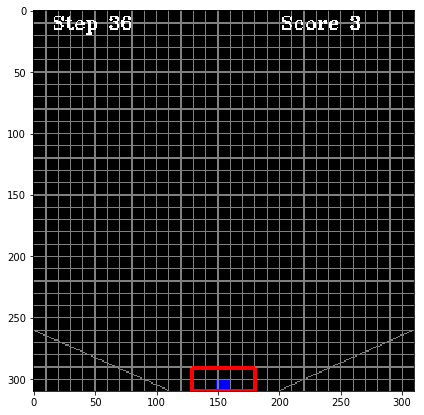

In [97]:
env.reset()
plt.figure(figsize = (7,7))
img = plt.imshow(env.render())

num_episodes = 50
ep_monitor_rate = 10

for i_episode in range(num_episodes):
    ep_monitor_flag = False
    if i_episode % ep_monitor_rate == 0:
        ep_monitor_flag = True

    # Initialize the environment and state
    display.clear_output(wait=True)
    print("episode %d running"%(i_episode+1))
    
    state = env.reset()
    state = torch.from_numpy(state.reshape(-1,93,93)).unsqueeze(0).to(device).type('torch.FloatTensor')
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done = env.step(action.item())
        
        next_state = torch.from_numpy(next_state.reshape(-1,93,93)).unsqueeze(0).to(device).type('torch.FloatTensor')
        reward = torch.tensor([reward], device=device).type('torch.FloatTensor')
        
        if ep_monitor_flag:
            img.set_data(cv2.cvtColor(env.render(),cv2.COLOR_BGR2RGB))

        if is_ipython:
            if ep_monitor_flag:
                display.clear_output(wait=True)
                display.display(plt.gcf())

        if not done:
            next_state = state
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

        if done:
            writer.add_scalar('data/TTbot/DQN/episode_durations', env.score, i_episode)
            break

    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()
writer.close()
plt.ioff()
plt.show()